In [1]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '2'
import sys


import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

# fix seed
sys.path.append('../..')
import utils.seed

# fix seed one more time
import torch
torch.manual_seed(42)
torch.cuda.manual_seed(42)

Using TensorFlow backend.


In [2]:
# external imports
import numpy as np
import json
import toml
import hashlib
import argparse
import pandas as pd
import shutil 

import keras
from keras.models import Model
from keras import layers
from keras.optimizers import Adam
from keras.models import load_model

from segmentation_models import Unet
from segmentation_models.backbones import get_preprocessing

from torch.utils.data import WeightedRandomSampler, DataLoader

from utils.datasets import ShipClassificationDataset, make_transform, to_dict
from utils.augmenters import get_augmenter
from utils.samplers import get_sampler
from utils.reproduce import save_commit_hash, save_config

import keras_backend
from keras_backend.generators import classification_generator
from keras_backend.callbacks import get_callbacks
from keras_backend.losses import get_losses
from keras_backend.metrics import get_metrics
from keras_backend.classification_models import get_classifier

from tqdm import tqdm_notebook as tqdm

In [15]:
EXP_DIR = '../../../checkpoints/resnet34_oof-0_cls-exp-10/'

In [16]:
def get_model(direcotry, mode='best', verbose=1):
    models = os.listdir(direcotry)
    if mode == 'best':
        checkpoint = sorted(models)[-1]
    if mode == 'last':
        checkpoint = 'last_epoch.h5'
    if verbose:
        print('All models:\n', sorted(models))
        print('Choose: ', checkpoint)
    return os.path.join(direcotry, checkpoint)

models_dir = os.path.join(EXP_DIR, 'models')
model_path = get_model(models_dir, 'best')

commit_path = os.path.join(EXP_DIR, 'commit.txt')
config_path = os.path.join(EXP_DIR, 'config.toml')

All models:
 ['last_epoch.h5', 'model-0.9285.h5', 'model-0.93.h5', 'model-0.93275.h5', 'model-0.946.h5', 'model-0.951.h5', 'model-0.956.h5', 'model-0.96225.h5', 'model-0.9655.h5', 'model-0.97275.h5']
Choose:  model-0.97275.h5


In [17]:
print(model_path)

../../checkpoints/resnet34_oof-0_cls-exp-10/models/model-0.97275.h5


In [18]:
# read config
config = toml.load(config_path)

In [19]:
# read model
model = load_model(model_path, compile=False)

In [20]:
# load data
test_ids = os.listdir(config['data']['test'])

transform = make_transform(preprocessing_fn=get_preprocessing(config['model']['architecture']))
dataset = ShipClassificationDataset(test_ids, config['data']['test'], mode='test', transform=transform)
dataloader = DataLoader(dataset, num_workers=3, shuffle=False)

In [21]:
import matplotlib.pyplot as plt

def visualize(image, label=None):
    plt.imshow(image.squeeze())
    if label is not None:
        plt.title(str(label))
    plt.show()

In [22]:
out_data = []

for i, sample in tqdm(enumerate(dataloader)):
    
    image_id = test_ids[i]
    image = sample['image'].numpy()
    label = model.predict(image)
    
    #visualize(image, label=label)
    
    out_data.append({
        'ImageId': image_id,
        'ShipProb': label.squeeze().round(5),
    })

A Jupyter Widget

In [23]:
df = pd.DataFrame(out_data)

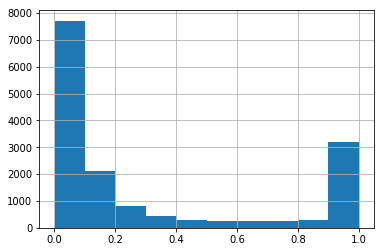

In [24]:
df['ShipProb'].hist()
plt.show()

In [25]:
# save predictions
pred_dir = os.path.join(EXP_DIR, 'predictions')
os.makedirs(pred_dir, exist_ok=True)
df.to_csv(os.path.join(pred_dir, 'prediction.csv'), index=False)

In [26]:
# create submission
df['EncodedPixels'] = df['ShipProb'].apply(lambda x: '1 1' if x > 0.5 else '')
sub_df = df.drop('ShipProb', axis=1)
sub_df.to_csv('../../data/submissions/{}.csv'.format(model.name), index=False)

In [27]:
path = '/home/geoalert/data/airbus/submissions/{}.csv'.format(model.name)

command = 'scp -oProxyCommand="ssh -W %h:%p geoalert@95.181.207.150" geoalert@gpunode:{path} .'.format(path=path)
print(command)

scp -oProxyCommand="ssh -W %h:%p geoalert@95.181.207.150" geoalert@gpunode:/home/geoalert/data/airbus/submissions/resnet34_oof-0_cls-exp-10.csv .


# visualization of not confident predictions

In [13]:
import matplotlib.pyplot as plt

In [34]:
hard_cases = df[(df['ShipProb'] > 0.7) & (df['ShipProb'] < 0.8)]['ImageId']
len(hard_cases)

330

In [ ]:
for i, image_id in enumerate(hard_cases):
    
    indx = test_ids.index(image_id)
    image = dataset[indx]['image']
    label = df[df['ImageId'] == image_id]['ShipProb'].values[0]
    
    visualize(image[..., ::-1], label=label)